# Color Doppler Ultrasound

In this notebook, we demonstrate how to process and visualize Color Doppler ultrasound data using the `zea` library. Doppler ultrasound is a non-invasive imaging technique that measures the frequency shift of ultrasound waves reflected from moving objects, such as blood flow in vessels.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/doppler_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/pipeline/doppler_example.ipynb)
&nbsp;
[![Hugging Face dataset](https://img.shields.io/badge/Hugging%20Face-Dataset-yellow?logo=huggingface)](https://huggingface.co/datasets/zeahub/zea-rotating-disk)

In [1]:
%%capture
%pip install zea

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["ZEA_DISABLE_CACHE"] = "1"

We'll import all necessary libraries and modules.

In [3]:
import matplotlib.pyplot as plt

import zea
from zea.doppler import color_doppler
import numpy as np
from zea import init_device
from zea.visualize import set_mpl_style
from zea.internal.notebooks import animate_images

zea: Using backend 'tensorflow'


We'll use the following parameters for this experiment.

In [4]:
n_frames = 25
n_transmits = 10

We will work with the GPU if available, and initialize using `init_device` to pick the best available device. Also, (optionally), we will set the matplotlib style for plotting.

In [5]:
init_device(verbose=False)
set_mpl_style()

## Loading data
To start, we will load some data from the [zea rotating disk](https://huggingface.co/datasets/zeahub/zea-rotating-disk) dataset, which is stored for convenience on the [Hugging Face Hub](https://huggingface.co/zeahub). You could also easily load your own data in zea format, using a local path instead of the HF URL.

For more ways and information to load data, please see the [Data documentation](../../data-acquisition.rst) or the data loading example notebook [here](../data/zea_data_example.ipynb).

Note that all acquisition parameters are also stored in the zea data format, such that when we load the data we can also construct `zea.Probe` and `zea.Scan` objects, that will be usefull later on in the pipeline.

In [6]:
with zea.File("hf://zeahub/zea-rotating-disk/L115V_1radsec.hdf5") as file:
    scan = file.scan()

    # Let's use a little bit less data for this demo
    selected_tx = np.linspace(0, scan.n_tx_total - 1, n_transmits, dtype=int)
    selected_frames = slice(n_frames)
    scan.set_transmits(selected_tx)

    data = file.load_data("raw_data", indices=[selected_frames, selected_tx])
    probe = file.probe()

L115V_1radsec.hdf5:   0%|          | 0.00/2.34G [00:00<?, ?B/s]

## B-mode reconstruction

First, we will use a default pipeline to process the data, and reconstruct the B-mode image from raw data. Note that the data as well as the parameters are passed along together as a dictionary to the pipeline. By default, the data will be assumed to be stored in the `data` key of the dictionary. Parameters are stored under their own name. This can all be customized, but for now we will use the defaults.

Note that we first need to prepare all parameters using `pipeline.prepare_parameters()`. This will create the flattened dictionary of tensors (converted to the backend of choice). You don't need this step if you already have created a dictionary of tensors with parameters manually yourself. However, since we currently have the parameters in a `zea.Probe` and `zea.Scan` object, we have to use the `pipeline.prepare_parameters()` method to extract them.

In [7]:
pipeline = zea.Pipeline.from_default(num_patches=1000, with_batch_dim=True)
params = pipeline.prepare_parameters(probe, scan)
bmode = pipeline(data=data, **params, return_numpy=True)["data"]

Let's visualize the B-mode images using a helper function.

In [8]:
animate_images(bmode, "doppler.gif", scan)

![Doppler B-mode Animation](./doppler.gif)

## Doppler reconstruction

Now, we will create a custom, shorter pipeline that computes the beamformed IQ data, and then computes the Color Doppler image from that. We will use the `color_doppler` function for this, which computes the Color Doppler image from the IQ data using a simple autocorrelation method.

In [9]:
pipeline = zea.Pipeline(
    [
        zea.ops.Demodulate(),
        zea.ops.PatchedGrid([zea.ops.TOFCorrection(), zea.ops.DelayAndSum()], num_patches=10),
        zea.ops.ChannelsToComplex(),
    ],
    jit_options="pipeline",
)

In [10]:
params = pipeline.prepare_parameters(probe, scan)
output = pipeline(data=data, **params)
data4doppler = output["data"]

Finally, we can visualize the Doppler image using matplotlib!

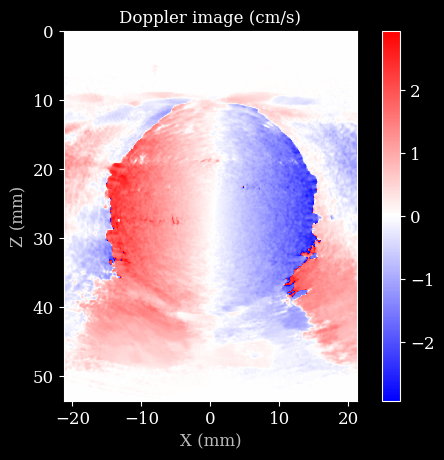

In [11]:
pulse_repetition_frequency = 1 / sum(scan.time_to_next_transmit[0])
d = color_doppler(
    data4doppler,
    probe.center_frequency,
    pulse_repetition_frequency,
    scan.sound_speed,
    hamming_size=10,  # spatial smoothing with Hamming window
)
plt.imshow(d * 100, cmap="bwr", extent=scan.extent * 1e3)
plt.title("Doppler image (cm/s)")
plt.xlabel("X (mm)")
plt.ylabel("Z (mm)")
plt.colorbar()
plt.show()